# Optimization dynamics via induced kernels

In this notebook, we study how different optimization algorithms induce **different kernels** that govern the local training dynamics of neural networks.


Given a neural model $h_{\theta}$, parametrized by $\theta\in\mathbb{R}^n$ and used to make predictions on a set of data $\{x_i,y_i\}_{i=1}^m$, the behavior of an optimizer can be characterized by its **induced kernel**:
$$\Theta = J M J^\top$$

where $J \in \mathbb{R}^{m \times n}$ is the Jacobian of outputs w.r.t. parameters:
$$
J =
\begin{bmatrix}
\nabla_{\theta} h_{\theta}(x_1)^\top \\
\vdots\\
\nabla_{\theta} h_{\theta}(x_m)^\top
\end{bmatrix}
\in\mathbb{R}^{m\times n}
$$
 and $M$ is a preconditioner that depends on the optimizer.

The condition number $\kappa(\Theta) = \frac{\sigma_{\max}(\Theta)}{ \sigma_{\min}(\Theta)}$, where $\sigma_{\max}(\Theta)$ and $\sigma_{\min}(\Theta)$ are the maximum and minimum singular values of $\Theta$ respectively, in particular determines the
 **convergence speed**, since poorly conditioned kernels ($\kappa(\Theta) \gg 1$) slow down the optimization process.


Different optimizers modify the Jacobian through the preconditioner $M$, improving the condition number of $\Theta$ and allowing for an adaptive choice of the learning rates and to update  different directions in the parameter space  at different rates.

We will compare four different methods, which correspond to four different kernels:

1. **Gradient Descent (GD)**: $M = I$ (no preconditioning)
2. **Adam**: $M = \rm{diag}(v)^{-1/2}$ adaptive diagonal scaling, with $v$ recursively updated component-wise as $v \leftarrow \beta_2 v + (1-\beta_2) g^2$ with $g$ the gradient estimate
3. **Adagrad**: $M=\rm{diag}(G)^{-1/2}$ cumulative gradient-based scaling with $G=\sum g^2$
4. **Damped Gauss–Newton**: $M = (J^\top J + \lambda I)^{-1}$, with $\lambda>0$,  approximate second order method that incorporates curvature

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

## 1. Parameter-space utilities

To analyze optimization kernels, we need to:
- Flatten parameters into vectors
- Reconstruct parameters from flat vectors
- Compute Jacobians of the network output with respect to the parameters

These utilities allow us to work explicitly in the parameter space.

In [2]:
def flatten_params(params):
    """Convert parameter list to single flat vector."""
    return torch.cat([p.reshape(-1) for p in params])

def get_param_shapes(params):
    """Extract shape information for all parameters."""
    return [p.shape for p in params]

def unflatten_like(vec, shapes):
    """Reconstruct parameter tensors from flat vector using shape information."""
    outs = []
    idx = 0
    for shp in shapes:
        num = int(np.prod(shp))
        outs.append(vec[idx:idx+num].reshape(shp))
        idx += num
    return outs

## 2. Jacobian computation

Here we compute $J \in \mathbb{R}^{m \times n}$, the Jacobian of network outputs w.r.t. parameters.




In [3]:
def compute_J(model, X):
    """
    Compute the Jacobian matrix J of network outputs w.r.t. parameters.

    Returns:
        J: (m, n) matrix where m=number of samples, n=number of parameters
    """
    params = list(model.parameters())
    m = X.shape[0]
    J_rows = []

    # For each data point, compute gradient of output w.r.t. all parameters
    for i in range(m):
        model.zero_grad()
        out = model(X[i:i+1]).sum()
        grads = torch.autograd.grad(out, params, retain_graph=True)
        g_flat = torch.cat([g.reshape(-1) for g in grads])
        J_rows.append(g_flat.detach())

    return torch.stack(J_rows, dim=0).double()  # Stack rows into (m, n) matrix

## 3. Computing the condition number

We measure kernel conditioning using the condition number:
$$\kappa(\Theta) = \frac{\sigma_{\max}(\Theta)}{\sigma_{\min}(\Theta)}$$
where $\sigma_{\max}(\Theta)$ and $\sigma_{\min}(\Theta)$ are the largest and the smallest singular values of $\Theta$, respectively.

Zero or near-zero singular values lead to a large condition number.

In [4]:
def cond_number(K):
    """
    Compute condition number of kernel matrix K.
    Only positive eigenvalues are considered (ignore near-zero values).
    """
    # Compute singular values (more numerically stable than eigenvalues)
    evals = torch.linalg.svdvals(K.cpu()).numpy()

    eps = 1e-9
    # Filter out numerical noise and zero eigenvalues
    pos = evals[evals > eps]

    if len(pos) == 0:
        return np.inf, pos

    # Condition number = sigma_max / sigma_min
    return pos.max() / pos.min(), pos

## 4. Dataset and neural network

We consider the target objective function

$$f(x) = \sin(\pi x(1)) + \cos(\pi x(2)).$$

We consider a small-data, overparameterized regime with:
- **Samples**: $\{x_i,y_i\}_{i=1}^m$, $y_i=f(x_i)$, $m = 20$
- **Parameters**: $n = 2 \times 20 + 20 \times 1 + 20 + 1 = 461$ (approximately) ??
- **Overparameterization ratio**: $m/n \approx 23$ (the network has ~23× more parameters than training samples)

In such regimes, neural networks can memorize the training data, and the kernel behavior becomes crucial for understanding generalization.

We intentionally use a tiny network, to guarantee tractability of kernel computations (full Jacobian computation for larger networks becomes prohibitive).





In [5]:
def make_dataset(m=20):
    """Generate synthetic 2D regression dataset."""
    X = np.random.uniform(-1, 1, size=(m, 2))
    y = np.sin(np.pi * X[:, 0]) + np.cos(np.pi * X[:, 1])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class TinyNet(nn.Module):
    """Small neural network for tractable kernel analysis."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

def make_fresh_model(seed=0):
    """Create a new model with fixed random seed for reproducibility."""
    torch.manual_seed(seed)
    return TinyNet()

## 5. Running the optimization methods

We compare the four optimization strategies:

- **GD**
- **Adagrad**
- **Adam**
- **Damped Gauss-Newton**




We track the condition number of their kernels throughout training and study how this influences the training procedure by considering the evolution of the training loss.
Lower condition numbers indicate better-conditioned kernels.

We also plot the singular values spectrum at a given iteration.



In [6]:
def run_gd(X, y, T=30, lr=1e-2, eig_record_it=10):
    """Run full-batch gradient descent and track kernel properties."""
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses, conds = [], []
    kernel_eigenvals = None

    for t in range(T):
        optimizer.zero_grad()
        loss = loss_fn(model(X), y)
        loss.backward()
        optimizer.step()

        # Compute Jacobian and induced kernel: K = J * J^T
        J = compute_J(model, X)
        K = 1e-2 * J @ J.t()

        cond, eigs = cond_number(K)
        losses.append(loss.item())
        conds.append(cond)

        # Record eigenvalues at specified iteration
        if t == eig_record_it:
            kernel_eigenvals = eigs

        print(f"[GD] iter {t:02d} | loss={losses[-1]:.2e} | cond={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals

In [7]:
def run_adam(X, y, T=30, lr=1e-3, eps=1e-8, eig_record_it=10):
    """Run Adam optimizer and compute induced kernel K_Adam = G * D * G^T."""
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Map each parameter to its position in the flattened parameter vector
    params = list(model.parameters())
    P = sum(p.numel() for p in params)
    index_map = {}
    offset = 0
    for p in params:
        sz = p.numel()
        index_map[p] = (offset, offset + sz)
        offset += sz

    losses = []
    conds  = []
    kernel_eigenvals = None

    for t in range(T):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Extract adaptive learning rates from Adam's second moment estimates
        v_flat = torch.zeros(P, dtype=torch.float64)
        for p in params:
            state = optimizer.state[p]
            v = state.get('exp_avg_sq', torch.zeros_like(p))
            i0, i1 = index_map[p]
            v_flat[i0:i1] = v.detach().reshape(-1).double()

        # Adam kernel: K = J * diag(lr / (sqrt(v) + eps)) * J^T
        J = compute_J(model, X)
        D = torch.diag(lr / (torch.sqrt(v_flat) + eps))
        K_adam = J @ D @ J.t()

        losses.append(loss.item())
        cond, eigenvalues = cond_number(K_adam)
        conds.append(cond)

        if t == eig_record_it:
            kernel_eigenvals = eigenvalues

        print(f"[Adam]    iter {t:02d} | loss={losses[-1]:.4e} | cond(K_Adam)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals

In [8]:
def run_adagrad(X, y, T=30, lr=1e-2, eps=1e-10, eig_record_it=10):
    """Run Adagrad optimizer and compute induced kernel K_Ada = G * D * G^T."""
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr, eps=eps)

    # Map parameters to flat vector indices
    params = list(model.parameters())
    P = sum(p.numel() for p in params)
    index_map = {}
    offset = 0
    for p in params:
        sz = p.numel()
        index_map[p] = (offset, offset + sz)
        offset += sz

    losses = []
    conds  = []
    kernel_eigenvals = None

    for t in range(T):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Extract accumulated squared gradients (Adagrad state)
        v_flat = torch.zeros(P, dtype=torch.float64)
        for p in params:
            state = optimizer.state[p]
            s = state.get('sum', torch.zeros_like(p))
            i0, i1 = index_map[p]
            v_flat[i0:i1] = s.detach().reshape(-1).double()

        # Adagrad kernel: K = J * diag(lr / (sqrt(sum) + eps)) * J^T
        J = compute_J(model, X)
        D = torch.diag(lr / (torch.sqrt(v_flat) + eps))
        K_adagrad = J @ D @ J.t()

        losses.append(loss.item())
        cond, eigenvalues = cond_number(K_adagrad)
        conds.append(cond)

        if t == eig_record_it:
            kernel_eigenvals = eigenvalues

        print(f"[Adagrad] iter {t:02d} | loss={losses[-1]:.4e} | cond(K_Ada)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals

In [9]:
def run_gauss_newton(X, y, T=20, lr=0.1, lambda_damp=1e-2, eig_record_it=10):
    """Run damped Gauss-Newton and compute induced kernel K_GN = G * (G^T G + lambda I)^{-1} * G^T."""
    model = make_fresh_model(seed=0)
    loss_fn = nn.MSELoss()

    params = list(model.parameters())
    shapes = get_param_shapes(params)

    losses = []
    conds  = []
    kernel_eigenvals = None

    for t in range(T):
        # Forward pass: compute residuals
        with torch.no_grad():
            pred = model(X)
        r = (pred - y).double()
        loss_val = loss_fn(pred, y).item()

        # Compute Jacobian matrix J
        J = compute_J(model, X)
        N, P = J.shape

        # Build normal matrix: B = J^T * J + lambda * I
        JT = J.t()
        B = JT @ J + lambda_damp * torch.eye(P, dtype=torch.float64)
        rhs = JT @ r.view(-1, 1)

        # Solve for Newton step: delta_theta = -(G^T G + lambda I)^{-1} * G^T * r
        delta_theta = -torch.linalg.solve(B, rhs).view(-1)

        # Update parameters
        with torch.no_grad():
            theta_flat = flatten_params(params).double()
            theta_new = theta_flat + lr * delta_theta
            new_tensors = unflatten_like(theta_new, shapes)
            for p, new_v in zip(params, new_tensors):
                p.copy_(new_v.to(p.dtype))

        # Compute Gauss-Newton kernel: K_GN = J * (J^T J + lambda I)^{-1} * J^T
        B_inv = torch.linalg.inv(B)
        K_gn = J @ B_inv @ J.t()

        losses.append(loss_val)
        cond, eigenvalues = cond_number(K_gn)
        conds.append(cond)

        if t == eig_record_it:
            kernel_eigenvals = eigenvalues

        print(f"[GN]      iter {t:02d} | loss={losses[-1]:.4e} | cond(K_GN)={conds[-1]:.2e}")

    return np.array(losses), np.array(conds), kernel_eigenvals

In [10]:
# Generate dataset
X, y = make_dataset(m=20)

# Run all four optimization methods and record loss, kernel condition, and eigenvalues
loss_gd,   cond_gd,   eig_GD   = run_gd(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_adam, cond_adam, eig_adam = run_adam(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_ada,  cond_ada,  eig_ada  = run_adagrad(X, y, T=75, lr=1e-2, eig_record_it=30)
loss_gn,   cond_gn,   eig_gn   = run_gauss_newton(X, y, T=75, lr=1.0, lambda_damp=1e-1, eig_record_it=30)

[GD] iter 00 | loss=1.15e+00 | cond=6.10e+05
[GD] iter 01 | loss=1.14e+00 | cond=6.30e+05
[GD] iter 02 | loss=1.13e+00 | cond=6.53e+05
[GD] iter 03 | loss=1.12e+00 | cond=6.78e+05
[GD] iter 04 | loss=1.11e+00 | cond=7.05e+05
[GD] iter 05 | loss=1.10e+00 | cond=7.34e+05
[GD] iter 06 | loss=1.09e+00 | cond=7.67e+05
[GD] iter 07 | loss=1.09e+00 | cond=8.02e+05
[GD] iter 08 | loss=1.08e+00 | cond=8.41e+05
[GD] iter 09 | loss=1.07e+00 | cond=8.84e+05
[GD] iter 10 | loss=1.06e+00 | cond=9.32e+05
[GD] iter 11 | loss=1.06e+00 | cond=9.83e+05
[GD] iter 12 | loss=1.05e+00 | cond=1.04e+06
[GD] iter 13 | loss=1.05e+00 | cond=1.10e+06
[GD] iter 14 | loss=1.04e+00 | cond=1.13e+06
[GD] iter 15 | loss=1.03e+00 | cond=1.20e+06
[GD] iter 16 | loss=1.03e+00 | cond=1.27e+06
[GD] iter 17 | loss=1.02e+00 | cond=1.36e+06
[GD] iter 18 | loss=1.02e+00 | cond=1.45e+06
[GD] iter 19 | loss=1.01e+00 | cond=1.56e+06
[GD] iter 20 | loss=1.01e+00 | cond=1.68e+06
[GD] iter 21 | loss=1.00e+00 | cond=1.81e+06
[GD] iter 

## 6. Plot the results

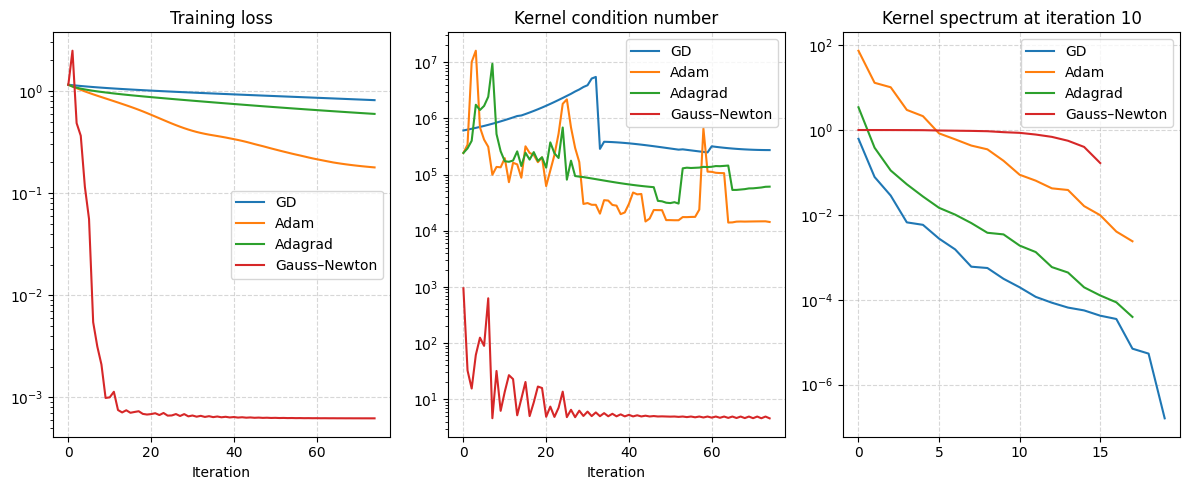

In [11]:
plt.figure(figsize=(12,5))

# Plot 1: Training loss curves
plt.subplot(1,3,1)
plt.semilogy(loss_gd, label="GD")
plt.semilogy(loss_adam, label="Adam")
plt.semilogy(loss_ada, label="Adagrad")
plt.semilogy(loss_gn, label="Gauss–Newton")
plt.title("Training loss")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.xlabel("Iteration")

# Plot 2: Kernel condition number evolution
plt.subplot(1,3,2)
plt.semilogy(cond_gd, label="GD")
plt.semilogy(cond_adam, label="Adam")
plt.semilogy(cond_ada, label="Adagrad")
plt.semilogy(cond_gn, label="Gauss–Newton")
plt.title("Kernel condition number")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.xlabel("Iteration")


# Plot 3: Eigenvalue spectrum at recorded iteration
plt.subplot(1,3,3)
plt.semilogy(eig_GD, label="GD")
plt.semilogy(eig_adam, label="Adam")
plt.semilogy(eig_ada, label="Adagrad")
plt.semilogy(eig_gn, label="Gauss–Newton")
plt.title("Kernel spectrum at iteration 10")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


## 7. Discussion 

**GD** exhibits a slow convergence, despite the large learning rates, due to the high conditioning induced by a poorly conditioned kernel, which reflects raw Jacobian anisotropy. This experimenatlly confirms that GD struggles on ill-conditioned problems.


 Adaptive gradient strategies such as **Adam** and **Adagrad** are faster than GD thanks to the diagonal preconditioning. The condition number decreases as the adaptive learning rate accumulates information, leading to a
faster loss decay but still limited by the fact that $M$ is diagonal  and thus misses parameter correlations.



 **Gauss–Newton** shows a dramatically better conditioning  than first-order methods via the inclusion of full second-order  curvature information via the approximated Hessian $(J^\top J + \lambda I)^{-1}$. This leads to
fastest convergence and most stable optimization, at the price of a larger per-iteration cost (the method requires the solution of a linear system at each step)





Adaptive first-order methods improve optimization dynamics through diagonal preconditioning, but second-order structure fundamentally reshapes the loss geometry and enables dramatically faster, more stable training.